# Anomality Detection Temperature IoT
Nov 10th 2023

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
print(os.getcwd())

/Users/razielar/Documents/git_rep/personal_repos/anomaly_detection/iot


In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

## 1) Input data

In [3]:
data_path = "data/Temperature_1week.csv"
df = pd.read_csv(data_path, header=None, parse_dates= [0]).rename(columns={0: "time", 1:"temperature"})
df["temperature"] = df["temperature"].str.replace(" °C", "").astype(float)
df

,time,temperature
0,2023-11-03 17:00:00,22.2000
1,2023-11-03 17:05:00,22.3000
2,2023-11-03 17:10:00,22.5000
3,2023-11-03 17:15:00,22.5000
4,2023-11-03 17:20:00,22.6000
...,...,...
2012,2023-11-10 16:40:00,22.3000
2013,2023-11-10 16:45:00,22.3000
2014,2023-11-10 16:50:00,22.3000
2015,2023-11-10 16:55:00,22.3000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         2017 non-null   datetime64[ns]
 1   temperature  2017 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.6 KB


In [5]:
processed_df = df.set_index(pd.to_datetime(df["time"]))["temperature"]

## 2) EDA

In [6]:
"""
Dickey-Fuller Hypothesis:
    Null-hypothesis: The series is non-stationary
    Alternative-hypothesis: The series is stationary
"""
p_value = sm.tsa.stattools.adfuller(processed_df)[1]
print(f"P-value: {p_value}")
if p_value < 0.05:
    conclusion= 'The series is stationary'
else:
    conclusion= 'The series is non-stationary'
print(conclusion)

P-value: 2.8891598941749117e-06
The series is stationary


In this case, a 5-minute window corresponds to 12 data points in an hour (60 minutes / 5 minutes = 12 data points).

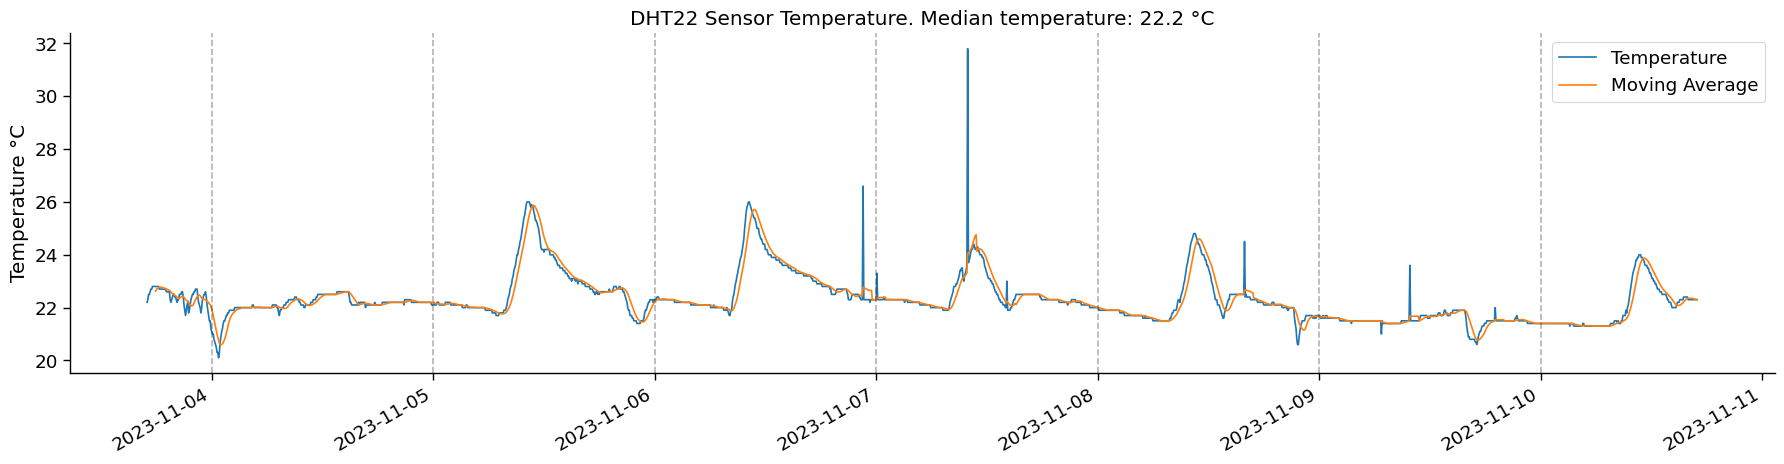

In [7]:
# Moving-Average
# Calculating the 5-minute moving average
WINDOW_SIZE  = 12 # For a 5-minute window (12 data points in an hour)
ma_ts = processed_df.rolling(WINDOW_SIZE).mean()

# Vars
median_temp = df["temperature"].median()
range_days = np.unique(np.array(df["time"], dtype="datetime64[D]")).astype(datetime)
range_days = range_days[1:len(range_days)]

# Plots
processed_df.plot(label="Temperature")
ma_ts.plot(label="Moving Average")
for i  in range_days:
    plt.axvline(i, color='k', linestyle='--', alpha=0.3)
plt.xlabel("")
plt.title(f"DHT22 Sensor Temperature. Median temperature: {median_temp} °C")
plt.ylabel("Temperature °C")
plt.legend()
plt.savefig("plots/dht22_temperature.png")
plt.show()

## 3) TS Decomposition: Trend + Seasonality + Residuals

In [8]:
processed_df = processed_df.asfreq("5T")
result = seasonal_decompose(processed_df, model="additive", period=24*12)

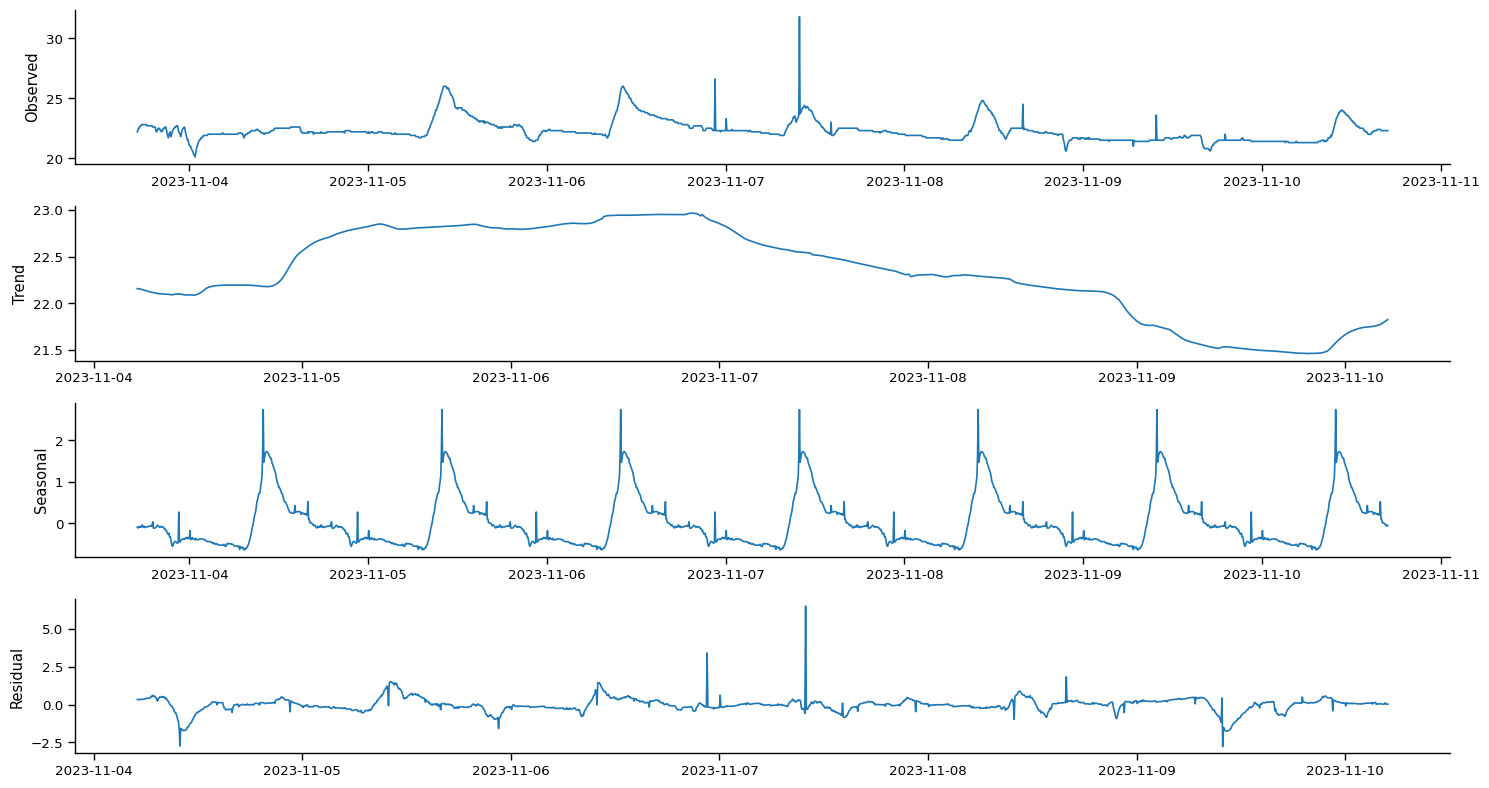

In [9]:
sns.set_context("paper", font_scale= 1.1)
plt.figure(figsize=(15, 8))

plt.subplot(411)
plt.plot(result.observed)
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(result.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(result.resid)
plt.ylabel('Residual')

plt.savefig("plots/ts_decomposition.png")
plt.tight_layout()

## 4) Series vs. Estimated

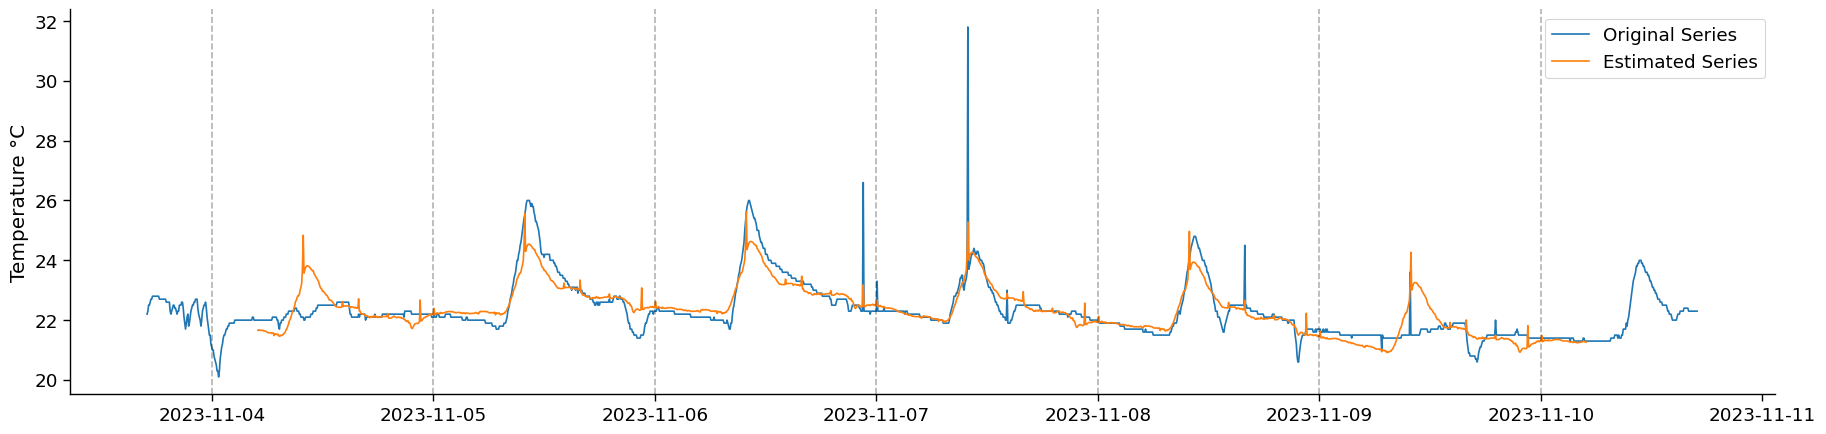

In [10]:
estimated = result.trend + result.seasonal

sns.set_context("paper", font_scale= 1.5)
plt.plot(processed_df, label= "Original Series")
plt.plot(estimated, label= "Estimated Series")
for i  in range_days:
    plt.axvline(i, color='k', linestyle='--', alpha=0.3)
plt.ylabel("Temperature °C")
plt.legend()
plt.savefig("plots/real_estimated.png")
plt.show()    

## 5) Darts Anomaly Detection

In [15]:
import darts
from darts.ad import QuantileDetector

ts = darts.TimeSeries.from_series(processed_df)
LOW_QUANTILE = 0.02
HIGH_QUANTILE = 0.98
anomaly_detector = QuantileDetector(low_quantile=LOW_QUANTILE, high_quantile=HIGH_QUANTILE)
anomalies = anomaly_detector.fit_detect(ts)

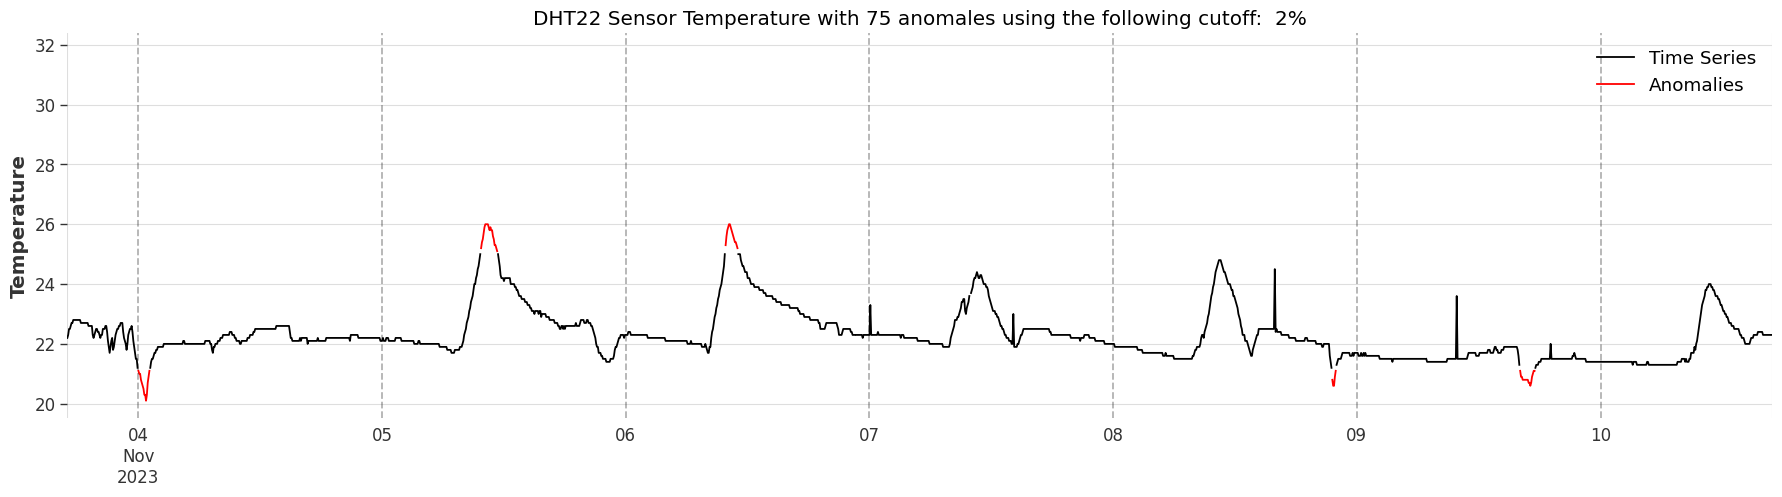

In [17]:
# Vars
anomaly_df = anomalies.pd_series().value_counts().reset_index().rename(columns={"index": "is_anomaly"})
number_anonalies = anomaly_df[anomaly_df["is_anomaly"] == 1]["count"].values.tolist()[0]

l = anomalies.pd_series().values
indexes = ts.pd_series().index
idx = pd.date_range(
        min(indexes), 
        max(indexes),
        freq="5T"
)

# Create DFs
anomalies_series = ts.pd_series()[np.array(l, dtype=bool)].reindex(idx, fill_value= np.nan)
nonanomalies_series = ts.pd_series()[~np.array(l, dtype=bool)].reindex(idx, fill_value= np.nan)
# Plots
nonanomalies_series.plot(color="black", label="Time Series")
anomalies_series.plot(color="red", label="Anomalies")
for i  in range_days:
        plt.axvline(i, color='k', linestyle='--', alpha=0.3)
plt.title(f"DHT22 Sensor Temperature with {number_anonalies} anomales using the following cutoff: {LOW_QUANTILE: .0%}")
plt.ylabel("Temperature")
plt.legend()
plt.savefig("plots/darts_anomalydetection.png")
plt.show()